# Generative AI and Risk Information

## What is Generative AI?

> Generative AI (GenAI) is a special type of Artificial Intelligence that can learn from and mimic large amounts of data to create content such as text, images, music, videos, code, and more.

## Application of Generative AI in Risk Management

- Information analysis
- Information provision
- Information automation

https://www.pwc.com/us/en/industries/financial-services/library/gen-ai-and-risk-management.html

### A Proof-of-Concept (PoC): Risk Agent

In this part of the course, we will create a chatbot that helps users find information about the risks and challenges faced by publicly listed companies, using their annual reports. Specifically, we will use a Large Language Model (LLM) to answer user questions by looking up relevant information in these reports. When a user asks a question, the chatbot will gather details from the appropriate reports to provide accurate answers.
This process enhances the LLM's responses by adding specific knowledge that it wouldn't have just from its initial training. This method is known as Retrieval Augmented Generation (RAG), and it is a popular way to build conversational AI applications.

> LLMs, are very large deep learning models that are pre-trained on vast amounts of data. They are highly flexible as a single model can perform completely different generative tasks such as answering questions, summarizing documents, translating languages and completing sentences.

> Retrieval Augmented Generation (RAG) RAG is a technique for improving the quality of LLM-generated responses by grounding the model on external sources of knowledge. Relevant external knowledge is retrieved from a knowledge base and used to augment the model's generation process. This approach can help mitigate the model's tendency to hallucinate or produce incorrect information, as it provides a more reliable source of context for the generation task.

While risk-related information from company reports is publicly available, it is quite tedious and resource-intensive to collect and structure it and to make it seamless available to decision makers that act upon such information. For example,
- Financial Analysts and Investment Professionals such as portfolio managers, equity analysts, and hedge fund managers, need to assess the risks and challenges of companies to make informed investment decisions. A risk agent could help them quickly analyze risk disclosures in annual reports, saving time and improving accuracy.
- Corporate Risk Managers need to benchmark their own risk disclosures against competitors or industry standards. A risk agent could help them identify trends in risk reporting and ensure compliance with regulatory requirements.
- ESG analysts focus on evaluating companies' sustainability and governance practices. Risk disclosures in annual reports often include information about environmental and social risks, which are critical for ESG assessments. A risk agent could help them extracting and analyzing ESG-related risks from annual reports to evaluate a company's sustainability profile.

Developing LLM-based applications requires you to choose one of the many proprietary or open-source LLM models. We use the proprietary LLM `command-r-plus` from [Cohere](https://cohere.com/command). Cohere offers trial API keys that can be used to send calls to their LLMs and return responses free of charge. Cohere's trial keys are rate-limited, and cannot be used for commercial purposes.

In order to get a trial API key, [create an account](https://dashboard.cohere.com/welcome/register) on Cohere and generate a trial API key.


<img src="img/cohere.png" alt="Cohere trial key" width="1000">

In the root directory of this project simply create a new file named `.env` where you paste in your trial API key.

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("HUGGINGFACE_API_KEY")

In the first step, we load the API keys into your project's environment, so the keys are available to us.

In [168]:
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Access the API keys
cohere_api_key = os.getenv("COHERE_API_KEY")
huggingface_api_key = os.getenv("HUGGINGFACE_API_KEY")

Moving on, we will primarily work with [LangChain](https://www.langchain.com/) and [LlamaIndex](https://docs.llamaindex.ai/en/stable/) which are both leading Python frameworks for building LLM-powered agents.

> In general terms, agents refer to artificial intelligence systems that can act with a higher degree of autonomy than traditional solutions. 
Designed to function independently, these systems can perform tasks and make decisions without continuous human intervention or needing predefined, hard-coded guidance - unlike traditional generative AI, which usually relies on predefined instructions and human oversight.

In our use case, we develop a agentic RAG system capable of extracting risk-related information from annual company reports. The agent orchestrates which report to retrieve information from based on the user's query and if no specific company is mentioned in the query searches the web to generate an answer.. The illustration below provides an idea of how this agentic RAG system looks like.

<img src="img/rag_agent.png" alt="Agentic RAG" width="700">

## Developing a Mulit-Document Risk Agent

### Parse documents

For demonstrative purposes, the original annual reports for a sample of DAX 40 companies can be found in `data/raw/reports/`.

In [4]:
reports = os.listdir('data/raw/reports/')
reports

['adidas_2023.pdf',
 'allianz_2023.pdf',
 'basf_2023.pdf',
 'bayer_2023.pdf',
 'beiersdorf_2023.pdf',
 'bmw_2023.pdf']

To read the annual reports, we use `SimpleDirectoryReader`, which offers an easy and efficient way to load data from local files and automatically parse the text, selecting the best file reader based on the file format. In our case, all the annual reports are in .pdf format.
For demonstration purposes, we will start with the 2023 annual report of Adidas. Later, we will apply the same process to the annual reports of all other DAX 40 companies. It's important to note that all the preprocessing steps outlined below are generic and can be applied without modification to the annual reports of other companies.

In [172]:
from llama_index.core import SimpleDirectoryReader

documents = SimpleDirectoryReader(input_files=['data/raw/reports/adidas_2023.pdf']).load_data(show_progress=True)
print(f"In total {len(documents)} Document objects have been loaded.")

Loading files:   0%|          | 0/1 [00:00<?, ?file/s]

Loading files: 100%|██████████| 1/1 [01:13<00:00, 73.37s/file]

In total 321 Document objects have been loaded.


As you can see `SimpleDirectoryReader` returns a list of `Document` objects where each element represents a single page from the annual report loaded before.

In [173]:
documents[0:3]

[Document(id_='45729c47-d90d-4313-8ec2-bfbddb626af9', embedding=None, metadata={'page_label': '1', 'file_name': 'adidas_2023.pdf', 'file_path': 'data\\raw\\reports\\adidas_2023.pdf', 'file_type': 'application/pdf', 'file_size': 20968677, 'creation_date': '2025-02-02', 'last_modified_date': '2025-02-02'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='2023\nANNUAL REPORT', path=None, url=None, mimetype=None), image_resource=None, audio_resource=None, video_resource=None, text_template='{metadata_str}\n\n{content}'),
 Document(id_='27ca959f-b388-45b8-afab-cc667c09ce4c', embedding=None, metadata={'page_label': '2', 'file_name': 'adidas_2023.

A `Document` object comes with a unique ID, some metadate, and the data found in the document differentiated by the following data types:
- text_resource
- image_resource
- audio_resource
- video_resource

In [175]:
vars(documents[165])

{'id_': '3ef23429-10c0-4e74-af05-1e315b6584fc',
 'embedding': None,
 'metadata': {'page_label': '166',
  'file_name': 'adidas_2023.pdf',
  'file_path': 'data\\raw\\reports\\adidas_2023.pdf',
  'file_type': 'application/pdf',
  'file_size': 20968677,
  'creation_date': '2025-02-02',
  'last_modified_date': '2025-02-02'},
 'excluded_embed_metadata_keys': ['file_name',
  'file_type',
  'file_size',
  'creation_date',
  'last_modified_date',
  'last_accessed_date'],
 'excluded_llm_metadata_keys': ['file_name',
  'file_type',
  'file_size',
  'creation_date',
  'last_modified_date',
  'last_accessed_date'],
 'relationships': {},
 'metadata_template': '{key}: {value}',
 'metadata_separator': '\n',
 'text_resource': MediaResource(embeddings=None, data=None, text="1 2 3 4 5 \nT O  O U R SHA REHO L D ERS  GRO U P  MAN A GEMEN T  REP O RT – \nO U R CO MPA N Y \nGRO U P  MAN A GEMEN T  REP O RT – \nF I N A N CI AL  REVI EW  \nCO N SO L I DA T ED  FI N AN CI A L \nST A T EMEN T S \nA D D I T I ON 

Next, we use the custom function `display_document_with_image_side_by_side()` to display and compare the text parsed by `SimpleDirectoryReader` with the original.

In [176]:
from util import display_document_with_image_side_by_side

display_document_with_image_side_by_side(
    document=documents[165],
    image_path='img/annual_report.png'
)

When using the text_resource in the Risk Agent, we do not need the header information which repeats on each page. This is just convoluting the content and should be removed from the `Document` objects. Similar redundant text can be found in the annual reports of the other companies. Moreover, we do not want to use the entire annual reports but only the pages which contain information about the companies' 'Risk and Opportunity'. Ultimately, we want to merge all relevant pages of one annual report into a single `Document` object. Otherwise, paragraphs that split across two pages will be handled separately in downstream processing.

In [177]:
pre_process_dict = {
    "adidas": {
        "pages": range(165, 187, 1),
        "string_to_remove": "1 2 3 4 5 \nT O  O U R SHA REHO L D ERS  GRO U P  MAN A GEMEN T  REP O RT – \nO U R CO MPA N Y \nGRO U P  MAN A GEMEN T  REP O RT – \nF I N A N CI AL  REVI EW  \nCO N SO L I DA T ED  FI N AN CI A L \nST A T EMEN T S \nA D D I T I ON A L I N FO RMA T I ON \n \n\\d{1,3} \n    \n    \n A N N U A L  R E P O R T  2 0 2 3",
    }
}

In [178]:
import re
from llama_index.core import Document

pages = pre_process_dict["adidas"].get("pages")
string_to_remove = pre_process_dict["adidas"].get("string_to_remove")
overall_text = ""

for page in pages:
    document = documents[page]
    text = document.text
    text = re.sub(string_to_remove, "", text)
    overall_text = "\n".join([overall_text, text])

report = Document(text=overall_text, metadata={'company': "adidas", 'year': 2023})

In [180]:
vars(report)

{'id_': 'd5d97044-fcbe-4ab2-9920-e1c0bdd46aa3',
 'embedding': None,
 'metadata': {'company': 'adidas', 'year': 2023},
 'excluded_embed_metadata_keys': [],
 'excluded_llm_metadata_keys': [],
 'relationships': {},
 'metadata_template': '{key}: {value}',
 'metadata_separator': '\n',
 'text_resource': MediaResource(embeddings=None, data=None, text="\n \nRisk and Opportunity Report \nIn order to remain competitive and ensure sustainable success, adidas consciously takes risks and \ncontinuously explores and develops opportunities. Our risk and opportunity management principles and \nsystem provide the framework for our company to conduct business in a well-controlled environment. \nRisk and opportunity management principles \nThe key objective of the risk and opportunity management is to support business success and protect the \ncompany as a going concern through an opportunity-focused but risk-aware decision-making framework. \nOur Enterprise Risk Management Policy outlines the principles

### Chunk documents

In RAG systems, chunking refers to the process of breaking a large document into smaller, manageable pieces or "chunks" before storing and processing them. These chunks are then indexed and used during the retrieval phase to provide relevant information to the LLM.

Chunking is essential in RAG for several reasons:
- **Efficient Retrieval**: By dividing large documents into smaller chunks, the system can quickly identify and retrieve only the most relevant pieces of information, rather than processing an entire document.
- **Improved Accuracy**: Smaller chunks help preserve context and ensure that the retrieved information is more focused and relevant to the user's query. This reduces the risk of irrelevant or inaccurate responses.
- **Token Limits**: LLMs have a maximum number of tokens that they can process at one time when generating responses. This is referred to as the model's context window size. Chunking documents into smaller parts allows to respect this context window size.

We use the `SentenceSplitter` class which splits the document into chunks with a preference for complete sentences. 

In [183]:
from llama_index.core.node_parser import SentenceSplitter

splitter = SentenceSplitter(
    chunk_size=256, 
    chunk_overlap=20)

chunks = splitter.get_nodes_from_documents([report])

In [184]:
len(chunks)

67

The annual report has been split into 67 chunks whereas each chunk has at most 256 tokens.

In [187]:
import pprint

for index, node in enumerate(chunks[:3]):
    pprint.pp(f"Node {index}: {node.text[:100]} ...")

('Node 0: Risk and Opportunity Report \n'
 'In order to remain competitive and ensure sustainable success, adidas c ...')
('Node 1: Risk and opportunity management system \n'
 'The Executive Board has overall responsibility for establish ...')
('Node 2: Our risk and opportunity management system is based on frameworks '
 'for enterprise risk management \n'
 'an ...')


### Vectorize chunks

After the documents have been chunked into smaller subsets, the next step is to translate them into vector representations. For this purpose we use an embedding model which converts the chunks' context into numerical vectors (see [second part of the course](day2_nlp.ipynb) for more details on embeddings).

We use `sentence-transformer` as embedding model for the vectorization of the annual report chunks. The model version we are using has a context window size of 256 tokens which is in line with the token size of the chunks that we have created in the step before. The model is hosted on [HuggingFace](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) and we use the free inference API offered by HuggingFace.

In [ ]:
from langchain_huggingface import HuggingFaceEndpointEmbeddings

embed_model = HuggingFaceEndpointEmbeddings(
    model="sentence-transformers/all-MiniLM-L6-v2",
    huggingfacehub_api_token=huggingface_api_key,
)

In [195]:
embedding = embed_model.embed_documents(texts=[chunks[0].text])

In [200]:
len(embedding[0])

384

The embedding model translates text (with at most 256 tokens) into a 1x384 vector.

Typically, one organizes a collection of embeddings within an index that is optimized for similarity search. We use [Faiss](https://faiss.ai/index.html), a library for efficient similarity search and clustering of dense vectors developed by Meta AI. Faiss is particularly well-suited for large datasets and high-dimensional vectors, making it a popular choice for embedding-based search tasks. During query time, the index uses Faiss to query for the top k embeddings, and returns the corresponding indices along with the corresponding chunks which serve as context information for the LLM to correctly answer a user query. 

We set up a `IndexFlatL2` which means the index stores the full vectors (no compression) and performs exhaustive search using Euclidean distance (L2). We save the generated Faiss index in memory using `InMemoryDocstore`.

In [209]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from util import convert_llama_to_langchain

index = faiss.IndexFlatL2(len(embed_model.embed_query("hello world")))

vector_store = FAISS(
    embedding_function=embed_model,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

In [210]:
vector_store.add_documents([convert_llama_to_langchain(chunk) for chunk in chunks])

['755d1e5c-ce8e-45dc-a0bb-6724e5ada69e',
 'b212b6ad-d498-4fb2-b597-9319c88f9e12',
 'edb5740e-a3db-4275-a405-4c9cd385753a',
 'a71346b4-9dc4-4f41-8349-634951c25f0f',
 'b0d5f278-9457-4476-b179-910974d65702',
 '051cb84a-047e-41c2-98ec-fcaefdfdbfa9',
 'bd4ad724-b1bc-4371-a3f9-e598a2d68e03',
 '2aaf6f52-6fac-4992-82c3-d5af905c6143',
 '087c4f33-6af1-4daf-b69f-a736fe7036ef',
 'a1e2826e-695e-4ee6-912b-21c51e9afe40',
 '3477c727-8de9-4f27-9289-dda4dd694b18',
 'fdc7622b-9d9c-4588-ba83-dfb7aa44a461',
 '6bb37394-7b59-4de3-8232-0735ee795070',
 'cfdeb384-004f-476a-8c81-95f468961dc3',
 'a4c1aa44-bed4-4fce-9cac-6f7bb6e31c81',
 '2a6f7d85-5fe2-4991-b41c-ac48d514ff9d',
 '343e9b7e-3312-4ac5-9de2-b4b20268854e',
 '26441276-0b67-4b68-93e9-05765a570a7f',
 '53c1b069-7da2-42bb-b457-69a92ed0df11',
 '2514ba7c-2d54-45ca-b809-4cc5906e3d9f',
 '59a21e13-121d-4f9c-be98-0d86460ec3ba',
 '7b7f2fd9-f440-48dd-9c54-b74173e5d36e',
 '321cd75b-10de-4b99-9a9c-66cf423f171d',
 '85c354d1-b692-40dc-ba32-78dceab886e2',
 '8916e5d3-01db-

We can now send a query to the vector store which retrieves the top k most relevant chunks from the index.

In [ ]:
vector_store.search(query="What is Adidas doing to mitigate climate change related risks?", search_type="similarity", k=3)

[Document(id='b8a8b09e-3b14-457f-a11b-e0fa9a9c4574', metadata={'company': 'adidas', 'year': 2023}, page_content='This framework applies to all adidas businesses \nworldwide and also sets our expectations of third-party business partners for managing personal\n \ninformation for or on behalf of adidas. Our Global Privacy Officer and the Global Privacy department drive \nthe operational establishment of the framework and monitoring capabilities to track and report its \nimplementation. During the implementation, they are continuously providing further implementation \nguidance and training. \nHazard risks \nAs climate change intensifies, the likelihood and intensity of natural disasters such as storms, floods, \ndroughts, pandemics, or heat waves increases, and so does adidas’ potential risk. In addition, our business \nactivities could be impacted by port congestions, strikes, riots, armed conflicts, or terrorist attacks. All of \nthe above could damage our offices, stores, or distribut

In [6]:
from util import parse_document, chunk_document, vectorize_chunks, pre_process_dict, convert_llama_to_langchain
from tqdm import tqdm
import asyncio
import nest_asyncio
nest_asyncio.apply()

for report in tqdm(reports):
    company = report.split('_')[0]
    year = int(report.split('_')[1].split('.')[0])

    document = parse_document(
        f'data/raw/reports/{report}', 
        pre_process_dict.get(company), 
        company=company, 
        year=year)
    chunks = chunk_document(
        document, 
        chunk_size=256, 
        chunk_overlap=20)
    
    chunks = [convert_llama_to_langchain(chunk) for chunk in chunks]
    
    try:
        await vector_store.aadd_documents(chunks)
        print(f"Vector store updated for {company} {year}.")
    except Exception as e:
        # Handle errors and debug
        print(f"Error updating vector store for {company} {year}: {e}")
        
        # If vector_index doesn't exist, create it
        if 'vector_store' not in locals():
            vector_store = asyncio.run(vectorize_chunks(chunks))
            print(f"Vector store created for {company} {year}.")
        else:
            print(f"Skipping {company} {year} due to error.")

  0%|          | 0/6 [00:00<?, ?it/s]

Error updating vector store for adidas 2023: name 'vector_store' is not defined


 17%|█▋        | 1/6 [00:30<02:32, 30.48s/it]

Vector store created for adidas 2023.


 33%|███▎      | 2/6 [00:50<01:37, 24.37s/it]

Vector store updated for allianz 2023.


 50%|█████     | 3/6 [01:02<00:55, 18.58s/it]

Vector store updated for basf 2023.


 67%|██████▋   | 4/6 [01:10<00:28, 14.32s/it]

Vector store updated for bayer 2023.


 83%|████████▎ | 5/6 [01:23<00:13, 13.94s/it]

Vector store updated for beiersdorf 2023.


100%|██████████| 6/6 [01:51<00:00, 18.57s/it]

Vector store updated for bmw 2023.


In [7]:
set([(doc.metadata['company'], doc.metadata['year']) for doc in vector_store.get_by_ids(vector_store.index_to_docstore_id.values())])

{('adidas', 2023),
 ('allianz', 2023),
 ('basf', 2023),
 ('bayer', 2023),
 ('beiersdorf', 2023),
 ('bmw', 2023)}

In [8]:
vector_store.save_local("studio/faiss_vector_store_sbert")

In [12]:
vector_store.search("Climate change related risks", filter={"company": "bayer", "year": 2023}, search_type="similarity", k=3)

[Document(id='437c24b1-fdfc-404a-a4eb-cea342fd66f1', metadata={'company': 'bayer', 'year': 2023}, page_content='Moreover, a negative public perception of Bayer re presents a risk. For example, modern agricultural \nmethods, such as the application of certain classes of crop protection products and the use of \nbiotechnology, are often the subject of intense public debate, which may adversely affect our reputation. \nThe risk of an increasingly negative public debate that  is not primarily based on science may, for example, \nlead to legislative and regulatory decisions that are unfavorable to our company,  significantly limiting the \nuse of our products or even resulting in voluntary or mandated product withdrawals. We are engaged in \nconstant dialogue with interest groups and regula tors to promote scientifically founded, rational and \nresponsible discussions and d ecision-making processes.  \nFurthermore, negative developments of a macroecono mic nature, such as crises in importan

In [ ]:
faiss_vector_store = FAISS.load_local(
    "./studio/faiss_vector_store",
    embeddings= HuggingFaceEndpointEmbeddings(
        model_name="Snowflake/snowflake-arctic-embed-l-v2.0"
    ),
    allow_dangerous_deserialization=True
)

In [137]:
set([(doc.metadata['company'], doc.metadata['year']) for doc in faiss_vector_store.get_by_ids(faiss_vector_store.index_to_docstore_id.values())])

{('adidas', 2023),
 ('allianz', 2023),
 ('basf', 2023),
 ('bayer', 2023),
 ('beiersdorf', 2023),
 ('bmw', 2023)}

Resources:
- [Let's talk about LlamaIndex and LangChain](https://superwise.ai/blog/lets-talk-about-llamaindex-and-langchain/)
- [LlamaIndex](https://docs.llamaindex.ai/en/stable/)
- [Advanced RAG techniques - An illustrated overview](https://pub.towardsai.net/advanced-rag-techniques-an-illustrated-overview-04d193d8fec6)

Try it with LangChain & LangGraph

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

In [2]:
# Vector Storage
from llama_index.core import load_index_from_storage, StorageContext

vector_index = load_index_from_storage(
    StorageContext.from_defaults(
        persist_dir=f"./studio/vector_index"
    )
)

In [8]:
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

faiss_vector_store = FAISS.load_local(
    "./studio/faiss_vector_store",
    embeddings=HuggingFaceEmbeddings(
        model_name="Snowflake/snowflake-arctic-embed-l-v2.0",
        model_kwargs={'device': 'cpu'},
        encode_kwargs={'normalize_embeddings': False}
    ),
    allow_dangerous_deserialization=True
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

w:\teaching\risk_analytics\.venv\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\julia\.cache\huggingface\hub\models--Snowflake--snowflake-arctic-embed-l-v2.0. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/203 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/251k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/784 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [10]:
faiss_vector_store.search("Credit risk", search_type='similarity_score_threshold')

[Document(id='fb4b23b1-92dd-4be5-a0ee-f296603bd59b', metadata={'company': 'allianz', 'year': 2023}, page_content='Credit risk arises from \npotential losses from non -recoverability of reinsurance \nreceivables, or due to default on benefits under in -force \nreinsurance treaties. Our ret rocession partners are carefully \nselected by a team of specialists. Besides focusing on companies \nwith a strong credit rating, we may further require letters of credit, \ncash deposits, funds withheld or assets held in trust, or other \nfinancial measures to further mitigate our exposure to credit risk. \nThe internal credit risk capital model takes into account the major \ndeterminants of credit risk for each instrument, including exposure at \ndefault, rating, seniority, collateral, and maturity. Additional \nparameters assigned to obligors are migration probabilities and \nobligor asset correlations reflecting dependencies within the portfolio. \nRatings are assigned to single obligors using a 

In [28]:
# LLM
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [12]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_search = TavilySearchResults(max_results=2)

In [13]:
dax_40 = ['adidas', 'airbus', 'allianz', 'basf', 'bayer', 'beiersdorf', 'bmw', 'brenntag', 'commerzbank', 'continental', 
'daimler truck', 'deutsche bank', 'deutsche boerse', 'deutsche post', 'deutsche telekom', 'eon', 'fresenius', 'fresenius medical care', 
'hannover rück', 'heidelberg materials', 'henkel', 'infineon technologies', 'mercedes benz', 'merck', 'mtu', 'münchener rück', 'porsche',
'porsche automobil holding', 'qiagen', 'rheinmetall', 'rwe', 'sap', 'sartorius', 'siemens', 'siemens energy', 'siemens healthineers',
'symrise', 'volkswagen', 'vonovia', 'zalando']

In [141]:
import operator
from typing import Annotated, Optional, TypedDict, List
from langgraph.graph import MessagesState
from pydantic import BaseModel, Field

class Company(BaseModel):
    name: str = Field(description="Name of DAX 40 company.")
    #year: int = Field(2023, description="Year of the annual report.")

class Companies(BaseModel):
    companies: Optional[List[Company]] = Field(description="List of DAX 40 companies with information about their annual reports.")

class Topic(BaseModel):
    topic: str = Field(description="Topic of the question.")

class OverallState(MessagesState):
    prompt: str
    context: Annotated[List[str], operator.add]  # Accumulated context from all companies
    companies: Companies
    final_answer: str

class DocumentState(TypedDict):
    prompt: str  # The user prompt
    company: Company  # The company related to the document (single value)
    topic: str # The topic extracted for the company (single value)
    context_detail: Annotated[List[str], operator.add]

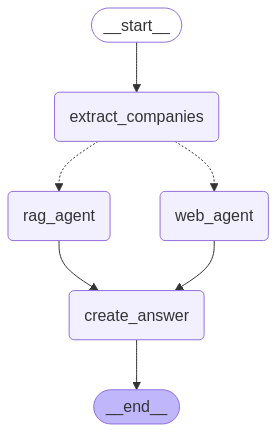

In [142]:
from IPython.display import Image, display
from langgraph.types import Send
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import HumanMessage, SystemMessage
from llama_index.core.vector_stores import MetadataFilter, MetadataFilters, FilterOperator
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.postprocessor import SimilarityPostprocessor

supervisor_instruction = """You are tasked with analyzing whether the following user prompt relates to one or several DAX 40 companies: {prompt}.

If you find any DAX 40 companies mentioned in the user prompt, map them to the ones mentioned in the following list:
{dax_40}.

It may well be that the user prompt is a more generic question that is not related to any specific company.
"""

topic_extraction_instruction = """You are part of an AI agent designed to answer questions about the risks DAX 40 companies
are facing. 

Your task is to extract the topic of the user prompt. The topic should be a short phrase that summarizes the main subject of the question.

Please make sure to retain specific keywords that are relevant to the topic.

This is the user prompt from which you should extract the topic: {prompt}.

Company names should not be included in the topic.
"""

single_answer_generation_instruction = """Based on the following context for {company}, generate an answer to the topic '{topic}': \n\n {context}.

If the context does not provide enough information, please answer that the annual report of {company} does not provide any information about the topic '{topic}'.
"""

final_answer_generation_instruction = """You are tasked to provide a concise answer to the following prompt: {prompt}.

To respond to the user, you are supposed to use the following contextual information: {context}.

If you find that the context contains repetitive information, please summarize it accordingly.

If the context mentions DAX 40 companies, please make sure to explicitly include them in your answer.
"""


def extract_companies(state: OverallState, dax_40: list = dax_40):

    prompt = state.get('prompt')
    dax_40 = ', '.join(dax_40)
    
    # Enforce structured output
    structured_llm = llm.with_structured_output(Companies)

    # System message
    system_message = supervisor_instruction.format(prompt=prompt, dax_40=dax_40)

    # Extract companies
    companies = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Extract the set of DAX 40 companies if there any mentioned. Otherwise return nothing.")])

    return {'companies': companies.companies}

def route_to_tool(state: OverallState):

    companies = state.get('companies', None)

    if companies is not None:
        prompt = state.get('prompt')

        structured_llm = llm.with_structured_output(Topic)
        system_message = topic_extraction_instruction.format(prompt=prompt)
        topic = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Extract the topic of the user prompt.")])

        return [Send("rag_agent", {"company": c, "topic": topic}) for c in companies]
    
    else:
        return 'web_agent'


def web_agent(state: OverallState):
    
    search_docs = tavily_search.invoke(state['prompt'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def rag_agent(state: DocumentState, vector_store: FAISS = faiss_vector_store):

    company = state.get('company')
    topic = state.get('topic')

    #     # Verify vector store before retrieval
    # assert vector_store is not None, "Vector store not initialized"
    # assert hasattr(vector_store, 'as_retriever'), "Invalid vector store object"

    # retriever = vector_store.as_retriever(
    #     search_type="similarity_score_threshold",
    #     search_kwargs={
    #         "k": 2,
    #         "score_threshold": 0.0},
    #     )

    # context = retriever.invoke(
    #     topic.topic,
    #     filter={
    #         "company": company,
    #         "year": 2023
    #         })

    context = vector_store.similarity_search(
        query=topic.topic, 
        k=2, 
        filter={"company": company.name, "year": 2023})    

    if len(context) == 0:
        answer = f"The annual report of {company.name} does not provide any information about the topic '{topic.topic}'."
    
    else:
        system_message = single_answer_generation_instruction.format(
            company=company.name, 
            topic=topic.topic, 
            context=' \n '.join([node.page_content for node in context]))
        answer = llm.invoke(system_message).content
    
    return {"context_detail": context ,"context": [answer]}


def create_answer(state: OverallState):
    
    prompt = state.get('prompt')
    context = state.get('context', None)

    system_message = final_answer_generation_instruction.format(prompt=prompt, context='\n\n'.join(context))
    final_answer = llm.invoke(system_message).content

    # Return the company-specific answer
    return {"final_answer": final_answer}


builder = StateGraph(OverallState)
builder.add_node("extract_companies", extract_companies)
builder.add_node("rag_agent", rag_agent)
builder.add_node("web_agent", web_agent)
builder.add_node("create_answer", create_answer)
builder.add_edge(START, "extract_companies")
builder.add_conditional_edges("extract_companies", route_to_tool, ["rag_agent", "web_agent"])
builder.add_edge("web_agent", "create_answer")
builder.add_edge("rag_agent", "create_answer")
builder.add_edge("create_answer", END)
graph = builder.compile()

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [50]:
type(faiss_vector_store)

langchain_community.vectorstores.faiss.FAISS

In [49]:
dir(faiss_vector_store)

['_FAISS__add',
 '_FAISS__from',
 '__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_aembed_documents',
 '_aembed_query',
 '_asimilarity_search_with_relevance_scores',
 '_cosine_relevance_score_fn',
 '_create_filter_func',
 '_embed_documents',
 '_embed_query',
 '_euclidean_relevance_score_fn',
 '_get_retriever_tags',
 '_max_inner_product_relevance_score_fn',
 '_normalize_L2',
 '_select_relevance_score_fn',
 '_similarity_search_with_relevance_scores',
 'aadd_documents',
 'aadd_texts',
 'add_documents',
 'add_embeddings',
 'add_texts',
 'adelete',
 'afrom_documents',
 'afrom_embeddings

In [111]:
company ='beiersdorf'
retriever = faiss_vector_store.as_retriever(
    search_type="similarity_score_threshold",
    k= 2,
    score_threshold= 0.0
    )

context = retriever.invoke(
    'risks related to the energy transition',
    filter={
        "company": company,
        "year": 2023
        }
    )

ValidationError: 1 validation error for VectorStoreRetriever
  Value error, `score_threshold` is not specified with a float value(0~1) in `search_kwargs`. [type=value_error, input_value={'vectorstore': <langchai... 'score_threshold': 0.0}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error

In [69]:
context

[Document(id='0bbd89f6-67e0-474f-bb32-8fe92a70fd14', metadata={'company': 'beiersdorf', 'year': 2023}, page_content='Where necessary, we adjusted the precise definitions of these \nrisks and our assessment of their probability and/or impact. This analysis showed no material year-on-\nyear change in the overall risk situation. Increased risk in some areas, such as climate-related effects \nANNUAL REPORT 2023\nTo the shareholders Combined Management Report Consolidated Financial Statements Additional Information\n158\nalong the entire value chain, were offset by lower risks in others, for example in relation to the energy \nsupply situation. In addition, in line with our cautious approach, we have currently completely removed \nopportunities beyond our medium-term planning from the quantitative net calculation of the risk \nportfolio. This approach was also taken in the previous year.'),
 Document(id='e234b9a9-8b7f-48a7-b6e5-6841b538be21', metadata={'company': 'beiersdorf', 'year': 2023}

In [93]:
temp = {"score_threshold": 0.3}
temp
temp.pop("score_threshold")

0.3

In [97]:
type(faiss_vector_store)

langchain_community.vectorstores.faiss.FAISS

In [ ]:
from langchain_community.vectorstores.utils import DistanceStrategy
faiss_vector_store.distance_strategy = DistanceStrategy.EUCLIDEAN_DISTANCE
faiss_vector_store.distance_strategy

<DistanceStrategy.COSINE: 'COSINE'>

In [119]:
faiss_vector_store.similarity_search(query="risks related to the energy transition", k=2, filter={"company": company, "year": 2023}, score_threshold=2.05)


[Document(id='0bbd89f6-67e0-474f-bb32-8fe92a70fd14', metadata={'company': 'beiersdorf', 'year': 2023}, page_content='Where necessary, we adjusted the precise definitions of these \nrisks and our assessment of their probability and/or impact. This analysis showed no material year-on-\nyear change in the overall risk situation. Increased risk in some areas, such as climate-related effects \nANNUAL REPORT 2023\nTo the shareholders Combined Management Report Consolidated Financial Statements Additional Information\n158\nalong the entire value chain, were offset by lower risks in others, for example in relation to the energy \nsupply situation. In addition, in line with our cautious approach, we have currently completely removed \nopportunities beyond our medium-term planning from the quantitative net calculation of the risk \nportfolio. This approach was also taken in the previous year.'),
 Document(id='e234b9a9-8b7f-48a7-b6e5-6841b538be21', metadata={'company': 'beiersdorf', 'year': 2023}

In [118]:
faiss_vector_store.similarity_search_with_relevance_scores(query="risks related to the energy transition", k=2, filter={"company": company, "year": 2023}, score_threshold=-10)

C:\Users\julia\AppData\Local\Temp\ipykernel_11568\3062729982.py:1: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='0bbd89f6-67e0-474f-bb32-8fe92a70fd14', metadata={'company': 'beiersdorf', 'year': 2023}, page_content='Where necessary, we adjusted the precise definitions of these \nrisks and our assessment of their probability and/or impact. This analysis showed no material year-on-\nyear change in the overall risk situation. Increased risk in some areas, such as climate-related effects \nANNUAL REPORT 2023\nTo the shareholders Combined Management Report Consolidated Financial Statements Additional Information\n158\nalong the entire value chain, were offset by lower risks in others, for example in relation to the energy \nsupply situation. In addition, in line with our cautious approach, we have currently completely removed \nopportunities beyond our medium-term planning from the quantitative net calculation of the risk \nportfolio. This approach was also taken

[(Document(id='0bbd89f6-67e0-474f-bb32-8fe92a70fd14', metadata={'company': 'beiersdorf', 'year': 2023}, page_content='Where necessary, we adjusted the precise definitions of these \nrisks and our assessment of their probability and/or impact. This analysis showed no material year-on-\nyear change in the overall risk situation. Increased risk in some areas, such as climate-related effects \nANNUAL REPORT 2023\nTo the shareholders Combined Management Report Consolidated Financial Statements Additional Information\n158\nalong the entire value chain, were offset by lower risks in others, for example in relation to the energy \nsupply situation. In addition, in line with our cautious approach, we have currently completely removed \nopportunities beyond our medium-term planning from the quantitative net calculation of the risk \nportfolio. This approach was also taken in the previous year.'),
  np.float32(-0.047091603)),
 (Document(id='e234b9a9-8b7f-48a7-b6e5-6841b538be21', metadata={'compan

In [143]:
prompt = "Is beiersdorf facing climate change risks?"

for event in graph.stream({"prompt": prompt}):
    print(event)

{'extract_companies': {'companies': [Company(name='beiersdorf')]}}
{'rag_agent': {'context_detail': [Document(id='e234b9a9-8b7f-48a7-b6e5-6841b538be21', metadata={'company': 'beiersdorf', 'year': 2023}, page_content='We \ntherefore still categorize this risk as major and possible. \n8. Climate change-related effects along the value chain\nIn this new risk category, we include all the possible impacts of climate change on our entire value \nchain – from procuring crucial raw materials and packaging to transporting products to end \ncustomers. In 2023, we arranged for an extensive external study on risk trends at our own locations \nbetween now and 2040. The resulting insights are now being translated into appropriate packages \nof measures. We have also begun to set up continuous monitoring of these risks, including for \ncritical ingredients. Particular attention is being paid to the water supply at our production sites. We \nare also constantly updating our emergency plans for critica